In [1]:
import os
os.environ['PYTHONHASHSEED'] = '1234'
import random
random.seed(43)
import numpy as np
np.random.seed(43)
import pandas as pd
import optuna   
import tensorflow as tf
tf.random.set_seed(43)
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report,  balanced_accuracy_score
from sklearn.metrics import f1_score
import gc
from tensorflow.keras import backend as K
from optuna.visualization import plot_optimization_history
import json

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-24 15:21:56.490842: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-24 15:21:56.491098: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-24 15:21:56.560817: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-24 15:21:56.704879: I tensorflow/core/platform/cpu_feature_guard.cc:18

In [2]:
SEED = 43
 # Se puede cambiar a "precision" o "recall" o "f1-score"
SCORE = "f1-score"

Score Trend Changes Score

In [3]:
def get_trend_changes_report_dict(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(
        y_df["is_changed_trend_test"][:-1], 
        y_df["is_changed_trend_predict"][:-1], 
        digits=4,
        output_dict=True,
        zero_division=0
    )

def trend_changes_score(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    return classification_report(
        y_df["is_changed_trend_test"][:-1], 
        y_df["is_changed_trend_predict"][:-1], digits=4
    )

def trend_changes_true(y_test: np.array, y_pred: np.array) -> float:
    """
    Calculate the trend changes score based on the test and predicted values.
    
    Args:
        y_test (np.array): True labels.
        y_pred (np.array): Predicted labels.
        
    Returns:
        float: The trend changes score.
    """
    y_df = pd.DataFrame([y_test, y_pred]).T
    y_df.columns = ["y_test", "y_pred"]
    y_df["y_test_shifted"] = y_df["y_test"].shift(-1)
    y_df["is_changed_trend_test"] = y_df["y_test"] != y_df["y_test_shifted"]
    y_df["y_predict_shifted"] = y_df["y_pred"].shift(-1)
    y_df["is_changed_trend_predict"] = y_df["y_pred"] != y_df["y_predict_shifted"]
    report = classification_report(
        y_df["is_changed_trend_test"][:-1],
        y_df["is_changed_trend_predict"][:-1],
        output_dict=True,
        zero_division=0
    )
    return report["True"][SCORE]

In [4]:
training_set = pd.read_csv("../../../data/post_cleaning/training_set.csv", parse_dates=['date'])
validation_set = pd.read_csv("../../../data/post_cleaning/validation_set.csv", parse_dates=['date'])
test_set = pd.read_csv("../../../data/post_cleaning/test_set.csv", parse_dates=['date'])
# Cargar datos
X_train = training_set.drop(columns=['target_trend','date']).values
y_train = training_set['target_trend'].values
X_val = validation_set.drop(columns=['target_trend','date']).values
y_val = validation_set['target_trend'].values
X_test = test_set.drop(columns=['target_trend','date']).values
y_test = test_set['target_trend'].values    
# Mapear clases (-1,0,1) -> (0,1,2) para LightGBM
cls_map = {-1:0, 0:1, 1:2}
inv_map = {v:k for k,v in cls_map.items()}
y_train = np.vectorize(cls_map.get)(y_train)
y_val   = np.vectorize(cls_map.get)(y_val)
y_test  = np.vectorize(cls_map.get)(y_test)

OPTIMIZACION CON OPTUNA

In [5]:
def objective(trial):
    os.environ['PYTHONHASHSEED'] = str(SEED)
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)
    # Hiperparámetros a optimizar
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    n_l1 = trial.suggest_int("n_l1", 32, 256, step=32)
    n_l2 = trial.suggest_int("n_l2", 32, 256, step=32)
    n_l3 = trial.suggest_int("n_l3", 16, 128, step=16)
    n_l4 = trial.suggest_int("n_l4", 8, 64, step=8)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    activation = trial.suggest_categorical("activation", ["relu", "tanh", "selu"])
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "rmsprop", "sgd"])
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    # Optimizer
    optimizer = {
        "adam": tf.keras.optimizers.Adam,
        "rmsprop": tf.keras.optimizers.RMSprop,
        "sgd": tf.keras.optimizers.SGD
    }[optimizer_name](learning_rate=learning_rate)

    # Modelo
    model = Sequential([
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(n_l1, activation=activation),
        Dropout(dropout_rate),
        Dense(n_l2, activation=activation),
        Dropout(dropout_rate),
        Dense(n_l3, activation=activation),
        Dropout(dropout_rate),
        Dense(n_l4, activation=activation),
        Dropout(dropout_rate),
        Dense(3, activation='linear')  # 3 clases
    ])

    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True
    )

    # Entrenamiento
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=60,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    # Predicción y evaluación con tu métrica personalizada
    y_pred_logits = model.predict(X_val)
    y_pred = np.argmax(y_pred_logits, axis=1)

    score = trend_changes_true(y_val, y_pred)
    # Liberar memoria GPU y limpiar sesión
    K.clear_session()
    gc.collect()
    return score  # Este es el valor que Optuna maximiza

In [6]:
study = optuna.create_study(
    direction="maximize", 
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=250)

[I 2025-08-24 13:31:33,133] A new study created in memory with name: no-name-760d976d-5b34-45ea-a195-a4940a8246a0
2025-08-24 13:31:33.270532: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-24 13:31:33.866418: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:31:36,172] Trial 0 finished with value: 0.0 and parameters: {'learning_rate': 2.2139290514335146e-05, 'n_l1': 160, 'n_l2': 64, 'n_l3': 32, 'n_l4': 24, 'dropout_rate': 0.42956874547429885, 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 256}. Best is trial 0 with value: 0.0.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:31:39,325] Trial 1 finished with value: 0.0 and parameters: {'learning_rate': 4.603487705829326e-05, 'n_l1': 128, 'n_l2': 96, 'n_l3': 16, 'n_l4': 56, 'dropout_rate': 0.4244695738724307, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 0 with value: 0.0.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:31:41,996] Trial 2 finished with value: 0.2711864406779661 and parameters: {'learning_rate': 1.036068923012556e-05, 'n_l1': 160, 'n_l2': 128, 'n_l3': 96, 'n_l4': 64, 'dropout_rate': 0.45433137891554387, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 2 with value: 0.2711864406779661.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:31:48,095] Trial 3 finished with value: 0.2391304347826087 and parameters: {'learning_rate': 6.709286383037111e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 64, 'n_l4': 64, 'dropout_rate': 0.36786354075356037, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 2 with value: 0.2711864406779661.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:31:52,042] Trial 4 finished with value: 0.1643835616438356 and parameters: {'learning_rate': 4.151887265119394e-05, 'n_l1': 64, 'n_l2': 224, 'n_l3': 48, 'n_l4': 48, 'dropout_rate': 0.14980838790351242, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 2 with value: 0.2711864406779661.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:31:57,573] Trial 5 finished with value: 0.3146067415730337 and parameters: {'learning_rate': 2.033425828832714e-05, 'n_l1': 256, 'n_l2': 160, 'n_l3': 128, 'n_l4': 16, 'dropout_rate': 0.29722459340921537, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 5 with value: 0.3146067415730337.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:32:01,615] Trial 6 finished with value: 0.0 and parameters: {'learning_rate': 0.0040789128952500725, 'n_l1': 256, 'n_l2': 256, 'n_l3': 96, 'n_l4': 16, 'dropout_rate': 0.21733916054340263, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 5 with value: 0.3146067415730337.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:32:04,044] Trial 7 finished with value: 0.0 and parameters: {'learning_rate': 0.0014011907433416567, 'n_l1': 256, 'n_l2': 224, 'n_l3': 32, 'n_l4': 64, 'dropout_rate': 0.2761320735057018, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 5 with value: 0.3146067415730337.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:32:07,379] Trial 8 finished with value: 0.0 and parameters: {'learning_rate': 0.0008572578878125053, 'n_l1': 64, 'n_l2': 192, 'n_l3': 16, 'n_l4': 8, 'dropout_rate': 0.16724449577646616, 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 5 with value: 0.3146067415730337.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:32:09,454] Trial 9 finished with value: 0.0 and parameters: {'learning_rate': 0.0015339533443798257, 'n_l1': 96, 'n_l2': 160, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.18927766972578491, 'activation': 'tanh', 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 5 with value: 0.3146067415730337.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:32:12,251] Trial 10 finished with value: 0.3148148148148148 and parameters: {'learning_rate': 0.0004211526474229757, 'n_l1': 192, 'n_l2': 32, 'n_l3': 128, 'n_l4': 24, 'dropout_rate': 0.004810004645591226, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:32:16,502] Trial 11 finished with value: 0.0 and parameters: {'learning_rate': 0.0002115866625211198, 'n_l1': 192, 'n_l2': 128, 'n_l3': 128, 'n_l4': 24, 'dropout_rate': 0.009232280612909063, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:32:19,767] Trial 12 finished with value: 0.05 and parameters: {'learning_rate': 0.00031423127345721704, 'n_l1': 192, 'n_l2': 32, 'n_l3': 128, 'n_l4': 32, 'dropout_rate': 0.008684039882169389, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:32:26,274] Trial 13 finished with value: 0.0 and parameters: {'learning_rate': 0.0001236692386629869, 'n_l1': 224, 'n_l2': 160, 'n_l3': 96, 'n_l4': 8, 'dropout_rate': 0.3274080951174306, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:32:28,895] Trial 14 finished with value: 0.0 and parameters: {'learning_rate': 0.009512899664646754, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 24, 'dropout_rate': 0.10795388858806215, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:32:31,549] Trial 15 finished with value: 0.19672131147540983 and parameters: {'learning_rate': 0.0005718533057173079, 'n_l1': 192, 'n_l2': 192, 'n_l3': 80, 'n_l4': 16, 'dropout_rate': 0.09235924637667614, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:32:35,150] Trial 16 finished with value: 0.13513513513513514 and parameters: {'learning_rate': 0.00014328066226152746, 'n_l1': 224, 'n_l2': 96, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.29298735304132467, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:32:38,279] Trial 17 finished with value: 0.0 and parameters: {'learning_rate': 1.9102430949682408e-05, 'n_l1': 128, 'n_l2': 96, 'n_l3': 112, 'n_l4': 16, 'dropout_rate': 0.3489771650656335, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:32:40,912] Trial 18 finished with value: 0.11267605633802817 and parameters: {'learning_rate': 0.000517604874733891, 'n_l1': 32, 'n_l2': 192, 'n_l3': 80, 'n_l4': 40, 'dropout_rate': 0.23461862033139, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:32:45,910] Trial 19 finished with value: 0.0 and parameters: {'learning_rate': 8.882058207050781e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 8, 'dropout_rate': 0.49075052935497565, 'activation': 'selu', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:32:48,094] Trial 20 finished with value: 0.0 and parameters: {'learning_rate': 0.0024225576899413867, 'n_l1': 192, 'n_l2': 128, 'n_l3': 64, 'n_l4': 32, 'dropout_rate': 0.06952567249870434, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:32:52,884] Trial 21 finished with value: 0.18705035971223022 and parameters: {'learning_rate': 1.0341518482214442e-05, 'n_l1': 160, 'n_l2': 128, 'n_l3': 96, 'n_l4': 48, 'dropout_rate': 0.4979251900918457, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:32:55,753] Trial 22 finished with value: 0.0392156862745098 and parameters: {'learning_rate': 1.8247815096455426e-05, 'n_l1': 160, 'n_l2': 160, 'n_l3': 112, 'n_l4': 24, 'dropout_rate': 0.3983669535411321, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:32:59,799] Trial 23 finished with value: 0.26666666666666666 and parameters: {'learning_rate': 1.0641900564411431e-05, 'n_l1': 128, 'n_l2': 32, 'n_l3': 96, 'n_l4': 16, 'dropout_rate': 0.2795565019938337, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:02,365] Trial 24 finished with value: 0.11320754716981132 and parameters: {'learning_rate': 3.314088488483133e-05, 'n_l1': 160, 'n_l2': 96, 'n_l3': 112, 'n_l4': 56, 'dropout_rate': 0.454760746237116, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:06,070] Trial 25 finished with value: 0.0 and parameters: {'learning_rate': 0.0002642157824487721, 'n_l1': 96, 'n_l2': 224, 'n_l3': 128, 'n_l4': 40, 'dropout_rate': 0.31413284336362834, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:08,019] Trial 26 finished with value: 0.22727272727272727 and parameters: {'learning_rate': 6.505758360239702e-05, 'n_l1': 192, 'n_l2': 128, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.24868708408714543, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:33:14,269] Trial 27 finished with value: 0.0 and parameters: {'learning_rate': 1.4650938274560615e-05, 'n_l1': 256, 'n_l2': 160, 'n_l3': 112, 'n_l4': 16, 'dropout_rate': 0.38096037545241584, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:33:17,107] Trial 28 finished with value: 0.0 and parameters: {'learning_rate': 2.5359356166720827e-05, 'n_l1': 224, 'n_l2': 256, 'n_l3': 128, 'n_l4': 48, 'dropout_rate': 0.037655662528939926, 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:20,532] Trial 29 finished with value: 0.1509433962264151 and parameters: {'learning_rate': 0.0005662282683322108, 'n_l1': 160, 'n_l2': 64, 'n_l3': 96, 'n_l4': 32, 'dropout_rate': 0.45354569074448686, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:24,790] Trial 30 finished with value: 0.0 and parameters: {'learning_rate': 0.00016419430219252946, 'n_l1': 96, 'n_l2': 192, 'n_l3': 48, 'n_l4': 8, 'dropout_rate': 0.13674835000705893, 'activation': 'relu', 'optimizer': 'sgd', 'batch_size': 256}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:28,562] Trial 31 finished with value: 0.20689655172413793 and parameters: {'learning_rate': 1.265572252485209e-05, 'n_l1': 128, 'n_l2': 32, 'n_l3': 96, 'n_l4': 16, 'dropout_rate': 0.2851516895129501, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:32,492] Trial 32 finished with value: 0.13953488372093023 and parameters: {'learning_rate': 1.0824940077574032e-05, 'n_l1': 128, 'n_l2': 32, 'n_l3': 80, 'n_l4': 24, 'dropout_rate': 0.41252654937676597, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:35,132] Trial 33 finished with value: 0.17543859649122806 and parameters: {'learning_rate': 2.723943179467936e-05, 'n_l1': 128, 'n_l2': 64, 'n_l3': 112, 'n_l4': 16, 'dropout_rate': 0.20704905877911298, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:33:34,968] Trial 34 finished with value: 0.16666666666666666 and parameters: {'learning_rate': 4.974236816190426e-05, 'n_l1': 160, 'n_l2': 96, 'n_l3': 64, 'n_l4': 56, 'dropout_rate': 0.3617097950888776, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:38,243] Trial 35 finished with value: 0.10752688172043011 and parameters: {'learning_rate': 1.9218979191146536e-05, 'n_l1': 192, 'n_l2': 64, 'n_l3': 96, 'n_l4': 16, 'dropout_rate': 0.3129323778692401, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:41,809] Trial 36 finished with value: 0.0 and parameters: {'learning_rate': 3.536790157739282e-05, 'n_l1': 96, 'n_l2': 32, 'n_l3': 48, 'n_l4': 64, 'dropout_rate': 0.2599289390537782, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:44,971] Trial 37 finished with value: 0.0 and parameters: {'learning_rate': 9.010268790600165e-05, 'n_l1': 256, 'n_l2': 32, 'n_l3': 128, 'n_l4': 24, 'dropout_rate': 0.34365223578297543, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:50,483] Trial 38 finished with value: 0.2882882882882883 and parameters: {'learning_rate': 5.223884352506029e-05, 'n_l1': 128, 'n_l2': 96, 'n_l3': 96, 'n_l4': 8, 'dropout_rate': 0.18005770328596782, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:54,338] Trial 39 finished with value: 0.2524271844660194 and parameters: {'learning_rate': 6.453199185168121e-05, 'n_l1': 160, 'n_l2': 128, 'n_l3': 112, 'n_l4': 8, 'dropout_rate': 0.15907683465949446, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:33:56,912] Trial 40 finished with value: 0.18823529411764706 and parameters: {'learning_rate': 4.584447071407648e-05, 'n_l1': 256, 'n_l2': 96, 'n_l3': 80, 'n_l4': 8, 'dropout_rate': 0.12080644319832129, 'activation': 'tanh', 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:34:02,928] Trial 41 finished with value: 0.23376623376623376 and parameters: {'learning_rate': 1.4199111541285777e-05, 'n_l1': 128, 'n_l2': 64, 'n_l3': 96, 'n_l4': 16, 'dropout_rate': 0.17693292579536157, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:34:07,033] Trial 42 finished with value: 0.19753086419753085 and parameters: {'learning_rate': 2.491495673359663e-05, 'n_l1': 96, 'n_l2': 160, 'n_l3': 96, 'n_l4': 8, 'dropout_rate': 0.2099586518390148, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:34:12,892] Trial 43 finished with value: 0.1348314606741573 and parameters: {'learning_rate': 1.5244440543604394e-05, 'n_l1': 64, 'n_l2': 64, 'n_l3': 128, 'n_l4': 16, 'dropout_rate': 0.06155102865548579, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:34:15,492] Trial 44 finished with value: 0.0 and parameters: {'learning_rate': 0.0004245939337313493, 'n_l1': 160, 'n_l2': 96, 'n_l3': 112, 'n_l4': 24, 'dropout_rate': 0.2663610955818441, 'activation': 'selu', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:34:18,522] Trial 45 finished with value: 0.0 and parameters: {'learning_rate': 0.0009145129338415925, 'n_l1': 128, 'n_l2': 128, 'n_l3': 32, 'n_l4': 8, 'dropout_rate': 0.2352062141180532, 'activation': 'relu', 'optimizer': 'rmsprop', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:34:23,143] Trial 46 finished with value: 0.0 and parameters: {'learning_rate': 1.0302762957639197e-05, 'n_l1': 128, 'n_l2': 32, 'n_l3': 96, 'n_l4': 16, 'dropout_rate': 0.43378481722588347, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:34:25,962] Trial 47 finished with value: 0.12903225806451613 and parameters: {'learning_rate': 2.154153676144142e-05, 'n_l1': 96, 'n_l2': 160, 'n_l3': 80, 'n_l4': 56, 'dropout_rate': 0.18538177146871465, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:34:33,172] Trial 48 finished with value: 0.19801980198019803 and parameters: {'learning_rate': 3.1509674993522853e-05, 'n_l1': 192, 'n_l2': 192, 'n_l3': 16, 'n_l4': 32, 'dropout_rate': 0.3019972081072449, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 64}. Best is trial 10 with value: 0.3148148148148148.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:34:34,439] Trial 49 finished with value: 0.3238095238095238 and parameters: {'learning_rate': 0.00021861367121153122, 'n_l1': 224, 'n_l2': 64, 'n_l3': 64, 'n_l4': 8, 'dropout_rate': 0.0012982254695479327, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 49 with value: 0.3238095238095238.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:34:39,482] Trial 50 finished with value: 0.0 and parameters: {'learning_rate': 0.0009038175489077985, 'n_l1': 224, 'n_l2': 96, 'n_l3': 64, 'n_l4': 8, 'dropout_rate': 0.02973442669266223, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 49 with value: 0.3238095238095238.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:34:42,678] Trial 51 finished with value: 0.26666666666666666 and parameters: {'learning_rate': 0.00021970813973167086, 'n_l1': 224, 'n_l2': 64, 'n_l3': 48, 'n_l4': 16, 'dropout_rate': 1.305998165157616e-05, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 49 with value: 0.3238095238095238.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:34:47,429] Trial 52 finished with value: 0.0 and parameters: {'learning_rate': 8.667190351943334e-05, 'n_l1': 256, 'n_l2': 32, 'n_l3': 64, 'n_l4': 8, 'dropout_rate': 0.09221413877467807, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 49 with value: 0.3238095238095238.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:34:52,679] Trial 53 finished with value: 0.0 and parameters: {'learning_rate': 0.00035182822334010226, 'n_l1': 192, 'n_l2': 64, 'n_l3': 80, 'n_l4': 8, 'dropout_rate': 0.03736737072316366, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 49 with value: 0.3238095238095238.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:34:57,705] Trial 54 finished with value: 0.0 and parameters: {'learning_rate': 0.0013177177200270171, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 48, 'dropout_rate': 0.3324395642159912, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 49 with value: 0.3238095238095238.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:00,971] Trial 55 finished with value: 0.07766990291262135 and parameters: {'learning_rate': 1.620875469560951e-05, 'n_l1': 256, 'n_l2': 96, 'n_l3': 112, 'n_l4': 16, 'dropout_rate': 0.01998380355228332, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 49 with value: 0.3238095238095238.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:04,002] Trial 56 finished with value: 0.0 and parameters: {'learning_rate': 0.00010694117701402627, 'n_l1': 192, 'n_l2': 128, 'n_l3': 64, 'n_l4': 24, 'dropout_rate': 0.08115195391367563, 'activation': 'selu', 'optimizer': 'sgd', 'batch_size': 256}. Best is trial 49 with value: 0.3238095238095238.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:05,433] Trial 57 finished with value: 0.37623762376237624 and parameters: {'learning_rate': 0.00019151973686459516, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 8, 'dropout_rate': 0.05773725446842077, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:08,357] Trial 58 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.0001748139454768102, 'n_l1': 224, 'n_l2': 96, 'n_l3': 128, 'n_l4': 8, 'dropout_rate': 0.04926722323033324, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:12,954] Trial 59 finished with value: 0.2708333333333333 and parameters: {'learning_rate': 0.00020326689045186336, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 8, 'dropout_rate': 0.04932434806059584, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:16,634] Trial 60 finished with value: 0.2809917355371901 and parameters: {'learning_rate': 0.00016811627872095016, 'n_l1': 224, 'n_l2': 96, 'n_l3': 128, 'n_l4': 8, 'dropout_rate': 0.014201936961745567, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:19,410] Trial 61 finished with value: 0.3191489361702128 and parameters: {'learning_rate': 0.0003132738801746497, 'n_l1': 224, 'n_l2': 96, 'n_l3': 128, 'n_l4': 8, 'dropout_rate': 0.018917925885221763, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:22,356] Trial 62 finished with value: 0.28205128205128205 and parameters: {'learning_rate': 0.0003250191627980185, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 8, 'dropout_rate': 0.05086771945174408, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:35:25,252] Trial 63 finished with value: 0.3008849557522124 and parameters: {'learning_rate': 0.0002565683632454726, 'n_l1': 256, 'n_l2': 96, 'n_l3': 128, 'n_l4': 8, 'dropout_rate': 0.06306942756698636, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:28,147] Trial 64 finished with value: 0.26666666666666666 and parameters: {'learning_rate': 0.00041648852102484763, 'n_l1': 256, 'n_l2': 128, 'n_l3': 128, 'n_l4': 8, 'dropout_rate': 0.06996283620703801, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:31,272] Trial 65 finished with value: 0.3047619047619048 and parameters: {'learning_rate': 0.00027442881544478815, 'n_l1': 256, 'n_l2': 32, 'n_l3': 128, 'n_l4': 16, 'dropout_rate': 0.11380332458548731, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:34,316] Trial 66 finished with value: 0.18556701030927836 and parameters: {'learning_rate': 0.0006914842802522808, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 16, 'dropout_rate': 0.11234626962696753, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:36,475] Trial 67 finished with value: 0.3619047619047619 and parameters: {'learning_rate': 0.00014256831199104645, 'n_l1': 256, 'n_l2': 32, 'n_l3': 112, 'n_l4': 16, 'dropout_rate': 0.0001381410050273037, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:41,404] Trial 68 finished with value: 0.32075471698113206 and parameters: {'learning_rate': 0.00013600544908293455, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 24, 'dropout_rate': 0.02438966505145468, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:45,672] Trial 69 finished with value: 0.33663366336633666 and parameters: {'learning_rate': 0.00013084336558574671, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 24, 'dropout_rate': 0.0020069286488448926, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:50,036] Trial 70 finished with value: 0.29357798165137616 and parameters: {'learning_rate': 0.00013201818770073405, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 24, 'dropout_rate': 0.023244587937665272, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:53,780] Trial 71 finished with value: 0.25688073394495414 and parameters: {'learning_rate': 0.00017594396769195732, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 24, 'dropout_rate': 0.0003582922884425425, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:35:57,448] Trial 72 finished with value: 0.2978723404255319 and parameters: {'learning_rate': 0.00013344006232753397, 'n_l1': 192, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.044111332322182006, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:01,811] Trial 73 finished with value: 0.2702702702702703 and parameters: {'learning_rate': 0.000110803445123909, 'n_l1': 192, 'n_l2': 64, 'n_l3': 112, 'n_l4': 24, 'dropout_rate': 0.01498744101629055, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:05,154] Trial 74 finished with value: 0.3488372093023256 and parameters: {'learning_rate': 0.00021231277375373988, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.0247080401886232, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:36:05,987] Trial 75 finished with value: 0.28846153846153844 and parameters: {'learning_rate': 0.00020584150351461372, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.027807777159642524, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:09,031] Trial 76 finished with value: 0.3364485981308411 and parameters: {'learning_rate': 0.00015626984927031404, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.05561023248709666, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 57 with value: 0.37623762376237624.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:13,251] Trial 77 finished with value: 0.3853211009174312 and parameters: {'learning_rate': 8.350311075246796e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.08287689459907885, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:17,628] Trial 78 finished with value: 0.35714285714285715 and parameters: {'learning_rate': 7.916241845945675e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.0848382342055661, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:22,239] Trial 79 finished with value: 0.3247863247863248 and parameters: {'learning_rate': 8.846889744662408e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.09488851853132872, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:26,839] Trial 80 finished with value: 0.2882882882882883 and parameters: {'learning_rate': 5.800890601663965e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.08064966495229618, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:31,384] Trial 81 finished with value: 0.3619047619047619 and parameters: {'learning_rate': 7.555674853405812e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.08976530625342302, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:35,577] Trial 82 finished with value: 0.2828282828282828 and parameters: {'learning_rate': 0.00010604143872573805, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.05295404087556389, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:38,047] Trial 83 finished with value: 0.32323232323232326 and parameters: {'learning_rate': 7.731771135078114e-05, 'n_l1': 256, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.1318971383923202, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:42,124] Trial 84 finished with value: 0.3300970873786408 and parameters: {'learning_rate': 0.000161245846767358, 'n_l1': 256, 'n_l2': 64, 'n_l3': 96, 'n_l4': 40, 'dropout_rate': 0.08142455925822797, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:36:46,473] Trial 85 finished with value: 0.21359223300970873 and parameters: {'learning_rate': 6.853834156105262e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.1014374552448506, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:51,331] Trial 86 finished with value: 0.14583333333333334 and parameters: {'learning_rate': 0.00011076746579046526, 'n_l1': 256, 'n_l2': 32, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.06833193663190942, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:54,952] Trial 87 finished with value: 0.0 and parameters: {'learning_rate': 0.000152487901237787, 'n_l1': 256, 'n_l2': 32, 'n_l3': 96, 'n_l4': 32, 'dropout_rate': 0.14232539671046524, 'activation': 'tanh', 'optimizer': 'sgd', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:36:58,446] Trial 88 finished with value: 0.37254901960784315 and parameters: {'learning_rate': 7.484180569637082e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.037216738689879104, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:37:03,296] Trial 89 finished with value: 0.3269230769230769 and parameters: {'learning_rate': 7.089840691259638e-05, 'n_l1': 256, 'n_l2': 32, 'n_l3': 96, 'n_l4': 40, 'dropout_rate': 0.0410006351564243, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:37:05,950] Trial 90 finished with value: 0.38181818181818183 and parameters: {'learning_rate': 3.823954314289322e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.03146849509387653, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:37:11,098] Trial 91 finished with value: 0.3238095238095238 and parameters: {'learning_rate': 4.115773029405687e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.08001530796857412, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:37:15,343] Trial 92 finished with value: 0.21487603305785125 and parameters: {'learning_rate': 5.751217311082161e-05, 'n_l1': 32, 'n_l2': 64, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.034366363521667595, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:37:18,445] Trial 93 finished with value: 0.30612244897959184 and parameters: {'learning_rate': 8.093310055195862e-05, 'n_l1': 256, 'n_l2': 32, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.00907289938636065, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 77 with value: 0.3853211009174312.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:37:23,546] Trial 94 finished with value: 0.40350877192982454 and parameters: {'learning_rate': 3.868575263462282e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 96, 'n_l4': 32, 'dropout_rate': 0.03981913562183158, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:37:28,842] Trial 95 finished with value: 0.26666666666666666 and parameters: {'learning_rate': 3.871825387762227e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 96, 'n_l4': 32, 'dropout_rate': 0.0423537478423547, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:37:33,952] Trial 96 finished with value: 0.3137254901960784 and parameters: {'learning_rate': 4.706036130848629e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 96, 'n_l4': 32, 'dropout_rate': 0.06175872845880177, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:37:33,876] Trial 97 finished with value: 0.0 and parameters: {'learning_rate': 0.0069116156295675165, 'n_l1': 256, 'n_l2': 96, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.07265294004541435, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:37:38,290] Trial 98 finished with value: 0.2391304347826087 and parameters: {'learning_rate': 9.83802746724541e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.09769538290528455, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:37:43,352] Trial 99 finished with value: 0.0 and parameters: {'learning_rate': 5.152437346203035e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 96, 'n_l4': 40, 'dropout_rate': 0.0327978396127499, 'activation': 'tanh', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:37:48,631] Trial 100 finished with value: 0.25925925925925924 and parameters: {'learning_rate': 3.198486877269726e-05, 'n_l1': 224, 'n_l2': 96, 'n_l3': 128, 'n_l4': 32, 'dropout_rate': 0.12373342383442892, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:37:53,466] Trial 101 finished with value: 0.35514018691588783 and parameters: {'learning_rate': 5.9493312881710796e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.010528498852299199, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:37:58,453] Trial 102 finished with value: 0.26804123711340205 and parameters: {'learning_rate': 5.929294109061528e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.047692332246173336, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:38:03,262] Trial 103 finished with value: 0.35185185185185186 and parameters: {'learning_rate': 7.666397055051815e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.012943618099323456, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:38:06,235] Trial 104 finished with value: 0.2545454545454545 and parameters: {'learning_rate': 7.677653694535261e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.011272581758673756, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:38:12,247] Trial 105 finished with value: 0.2736842105263158 and parameters: {'learning_rate': 4.1774223914188464e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 128, 'n_l4': 56, 'dropout_rate': 0.057982713450649745, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:38:17,778] Trial 106 finished with value: 0.3018867924528302 and parameters: {'learning_rate': 6.567835213886092e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.03832518944135131, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:38:23,144] Trial 107 finished with value: 0.27722772277227725 and parameters: {'learning_rate': 2.8128520157584827e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 96, 'n_l4': 40, 'dropout_rate': 0.08906623143120662, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:38:28,311] Trial 108 finished with value: 0.34545454545454546 and parameters: {'learning_rate': 0.00011740857555411549, 'n_l1': 256, 'n_l2': 96, 'n_l3': 128, 'n_l4': 48, 'dropout_rate': 0.014271236698494446, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:38:33,833] Trial 109 finished with value: 0.3418803418803419 and parameters: {'learning_rate': 3.751141439111884e-05, 'n_l1': 192, 'n_l2': 64, 'n_l3': 96, 'n_l4': 56, 'dropout_rate': 0.030571765623145307, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:38:36,311] Trial 110 finished with value: 0.28846153846153844 and parameters: {'learning_rate': 9.651922252875549e-05, 'n_l1': 256, 'n_l2': 96, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.10485694298592704, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:38:40,701] Trial 111 finished with value: 0.275 and parameters: {'learning_rate': 0.00019238108383258976, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.026389409442807665, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:38:46,058] Trial 112 finished with value: 0.36538461538461536 and parameters: {'learning_rate': 5.3630931263496574e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.01889930903570953, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:38:51,446] Trial 113 finished with value: 0.2803738317757009 and parameters: {'learning_rate': 5.337525210665559e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.0473963225667887, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:38:56,553] Trial 114 finished with value: 0.23853211009174313 and parameters: {'learning_rate': 4.533823242238592e-05, 'n_l1': 224, 'n_l2': 224, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.07171944171328333, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:39:01,071] Trial 115 finished with value: 0.3018867924528302 and parameters: {'learning_rate': 7.624986354492543e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 32, 'dropout_rate': 0.012189175157161078, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:39:03,326] Trial 116 finished with value: 0.32142857142857145 and parameters: {'learning_rate': 6.087763463248598e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.05848451424575554, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:39:06,874] Trial 117 finished with value: 0.39603960396039606 and parameters: {'learning_rate': 9.362690245444094e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.020098457375152232, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:39:09,713] Trial 118 finished with value: 0.057971014492753624 and parameters: {'learning_rate': 9.251835632663341e-05, 'n_l1': 192, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.03719840063166929, 'activation': 'tanh', 'optimizer': 'sgd', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:39:15,480] Trial 119 finished with value: 0.2956521739130435 and parameters: {'learning_rate': 2.430854895415159e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 48, 'dropout_rate': 0.08725799835828976, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:39:20,723] Trial 120 finished with value: 0.23423423423423423 and parameters: {'learning_rate': 2.9300961307179273e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.052039091514437606, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:39:25,717] Trial 121 finished with value: 0.2912621359223301 and parameters: {'learning_rate': 6.841276308343152e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.020359914556419643, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:39:29,613] Trial 122 finished with value: 0.28 and parameters: {'learning_rate': 8.767437945652698e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 3.7138506496399437e-06, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:39:33,726] Trial 123 finished with value: 0.34545454545454546 and parameters: {'learning_rate': 0.00012076729939063241, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.019061138637129677, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:39:36,665] Trial 124 finished with value: 0.2803738317757009 and parameters: {'learning_rate': 5.195563594567031e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.009248852249063473, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:39:41,705] Trial 125 finished with value: 0.2926829268292683 and parameters: {'learning_rate': 3.384013276001151e-05, 'n_l1': 192, 'n_l2': 64, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.034971168227577024, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:39:44,466] Trial 126 finished with value: 0.16470588235294117 and parameters: {'learning_rate': 8.01400270580064e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 96, 'n_l4': 32, 'dropout_rate': 0.0664753097331738, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:39:49,029] Trial 127 finished with value: 0.24761904761904763 and parameters: {'learning_rate': 0.00010714384273303852, 'n_l1': 256, 'n_l2': 96, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.044835781767458865, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:39:53,651] Trial 128 finished with value: 0.2376237623762376 and parameters: {'learning_rate': 0.0001440378458295536, 'n_l1': 224, 'n_l2': 32, 'n_l3': 96, 'n_l4': 40, 'dropout_rate': 0.026853302411737952, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:39:57,997] Trial 129 finished with value: 0.25742574257425743 and parameters: {'learning_rate': 0.0002540862036961358, 'n_l1': 256, 'n_l2': 64, 'n_l3': 128, 'n_l4': 40, 'dropout_rate': 0.07497325568510646, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:02,390] Trial 130 finished with value: 0.3119266055045872 and parameters: {'learning_rate': 6.434099222085041e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 24, 'dropout_rate': 0.058374143211314095, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:04,095] Trial 131 finished with value: 0.30303030303030304 and parameters: {'learning_rate': 0.00023415616545717093, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.023728124088479817, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:07,895] Trial 132 finished with value: 0.3269230769230769 and parameters: {'learning_rate': 0.0001794143993440648, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.008986664207345809, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:12,752] Trial 133 finished with value: 0.30357142857142855 and parameters: {'learning_rate': 4.42813103862182e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.019931448721685417, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:17,327] Trial 134 finished with value: 0.2619047619047619 and parameters: {'learning_rate': 0.00010163255988275744, 'n_l1': 64, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.046484378334687576, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:21,210] Trial 135 finished with value: 0.35051546391752575 and parameters: {'learning_rate': 0.00012115644876127764, 'n_l1': 192, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.03121599230541162, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:40:25,433] Trial 136 finished with value: 0.34782608695652173 and parameters: {'learning_rate': 0.0001256869728289989, 'n_l1': 192, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.03448937338069196, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:30,051] Trial 137 finished with value: 0.30303030303030304 and parameters: {'learning_rate': 7.065547816763229e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 24, 'dropout_rate': 0.006405726939870744, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:34,084] Trial 138 finished with value: 0.3697478991596639 and parameters: {'learning_rate': 8.796835812461428e-05, 'n_l1': 192, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.03914593862518483, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:40:34,665] Trial 139 finished with value: 0.21739130434782608 and parameters: {'learning_rate': 5.4728746282408824e-05, 'n_l1': 256, 'n_l2': 96, 'n_l3': 128, 'n_l4': 56, 'dropout_rate': 0.06314896715602256, 'activation': 'tanh', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:39,440] Trial 140 finished with value: 0.25742574257425743 and parameters: {'learning_rate': 9.60798043963449e-05, 'n_l1': 256, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.042754375849410636, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:44,371] Trial 141 finished with value: 0.23076923076923078 and parameters: {'learning_rate': 8.327955920369163e-05, 'n_l1': 160, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.03100101410720885, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:48,388] Trial 142 finished with value: 0.352 and parameters: {'learning_rate': 0.0001469326569891742, 'n_l1': 192, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.05328087619355607, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:40:51,862] Trial 143 finished with value: 0.15384615384615385 and parameters: {'learning_rate': 0.00015639837997737002, 'n_l1': 192, 'n_l2': 256, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.04980327019561739, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:56,440] Trial 144 finished with value: 0.32653061224489793 and parameters: {'learning_rate': 7.710049550786821e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.08333919272422437, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:40:59,828] Trial 145 finished with value: 0.26262626262626265 and parameters: {'learning_rate': 0.0001430163748176096, 'n_l1': 256, 'n_l2': 64, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.018594086834282916, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:41:03,885] Trial 146 finished with value: 0.0 and parameters: {'learning_rate': 5.847394119259978e-05, 'n_l1': 192, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.0641710263098204, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:41:07,967] Trial 147 finished with value: 0.3119266055045872 and parameters: {'learning_rate': 4.7809701738742014e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 8, 'dropout_rate': 0.07370973103680153, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:41:13,204] Trial 148 finished with value: 0.20224719101123595 and parameters: {'learning_rate': 9.172367710608537e-05, 'n_l1': 256, 'n_l2': 32, 'n_l3': 80, 'n_l4': 56, 'dropout_rate': 0.05377685368483442, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:41:18,306] Trial 149 finished with value: 0.2553191489361702 and parameters: {'learning_rate': 3.872809611436499e-05, 'n_l1': 160, 'n_l2': 64, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.041057475414830666, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:41:22,457] Trial 150 finished with value: 0.39655172413793105 and parameters: {'learning_rate': 6.358202404721934e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 56, 'dropout_rate': 0.012645566401907431, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:41:26,633] Trial 151 finished with value: 0.2222222222222222 and parameters: {'learning_rate': 6.579829388955975e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 56, 'dropout_rate': 0.010623980288143738, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:41:30,525] Trial 152 finished with value: 0.3146067415730337 and parameters: {'learning_rate': 7.287666626637395e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 56, 'dropout_rate': 0.001606165445605955, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:41:34,358] Trial 153 finished with value: 0.27586206896551724 and parameters: {'learning_rate': 8.513824461719594e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 48, 'dropout_rate': 0.01894036308934892, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:41:35,981] Trial 154 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.0001080246815985698, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.026251365946196113, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:41:41,364] Trial 155 finished with value: 0.3409090909090909 and parameters: {'learning_rate': 0.0001071807752611278, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.03567643673392054, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:41:45,762] Trial 156 finished with value: 0.29906542056074764 and parameters: {'learning_rate': 0.00012004377094432325, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.054486448046082436, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 94 with value: 0.40350877192982454.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:41:50,399] Trial 157 finished with value: 0.43010752688172044 and parameters: {'learning_rate': 5.038299029060178e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.025097897226378094, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:41:56,123] Trial 158 finished with value: 0.29357798165137616 and parameters: {'learning_rate': 3.527430572847887e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.024911428315842123, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:42:01,802] Trial 159 finished with value: 0.34408602150537637 and parameters: {'learning_rate': 4.94568288763024e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 56, 'dropout_rate': 0.16064561965749205, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:42:03,877] Trial 160 finished with value: 0.22641509433962265 and parameters: {'learning_rate': 5.837717458061348e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.028886928970578776, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:42:08,873] Trial 161 finished with value: 0.33043478260869563 and parameters: {'learning_rate': 0.0001789950226423005, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.03954636418288096, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:42:15,576] Trial 162 finished with value: 0.32432432432432434 and parameters: {'learning_rate': 4.4189759850475326e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.015604966236285218, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:42:20,766] Trial 163 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 6.346920539833518e-05, 'n_l1': 192, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.04657739834838051, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:42:24,978] Trial 164 finished with value: 0.28846153846153844 and parameters: {'learning_rate': 0.00010059524811426176, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.003095976716695977, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:42:28,726] Trial 165 finished with value: 0.0 and parameters: {'learning_rate': 0.0029919749072023984, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.09047496091112267, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:42:32,114] Trial 166 finished with value: 0.25882352941176473 and parameters: {'learning_rate': 0.00014050473036236852, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 56, 'dropout_rate': 0.02878575211571813, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:42:34,520] Trial 167 finished with value: 0.3185840707964602 and parameters: {'learning_rate': 8.870787651393735e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 8, 'dropout_rate': 0.19751503199729353, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:42:40,229] Trial 168 finished with value: 0.39316239316239315 and parameters: {'learning_rate': 5.108553982602232e-05, 'n_l1': 192, 'n_l2': 32, 'n_l3': 96, 'n_l4': 16, 'dropout_rate': 0.06295968681073451, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:42:43,233] Trial 169 finished with value: 0.0 and parameters: {'learning_rate': 5.158196080038862e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 96, 'n_l4': 16, 'dropout_rate': 0.06473283613918658, 'activation': 'tanh', 'optimizer': 'sgd', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:42:49,445] Trial 170 finished with value: 0.0 and parameters: {'learning_rate': 3.8382719858143295e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 80, 'n_l4': 16, 'dropout_rate': 0.1040986781383807, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:42:54,145] Trial 171 finished with value: 0.2962962962962963 and parameters: {'learning_rate': 6.952539308827877e-05, 'n_l1': 192, 'n_l2': 32, 'n_l3': 112, 'n_l4': 8, 'dropout_rate': 0.07648767783395449, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:42:59,178] Trial 172 finished with value: 0.3114754098360656 and parameters: {'learning_rate': 5.697236195108476e-05, 'n_l1': 192, 'n_l2': 32, 'n_l3': 96, 'n_l4': 32, 'dropout_rate': 0.058929934132884276, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:43:02,207] Trial 173 finished with value: 0.25688073394495414 and parameters: {'learning_rate': 4.2405795005882996e-05, 'n_l1': 192, 'n_l2': 32, 'n_l3': 16, 'n_l4': 64, 'dropout_rate': 0.039257428822828296, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:43:07,235] Trial 174 finished with value: 0.2807017543859649 and parameters: {'learning_rate': 8.105693214997645e-05, 'n_l1': 192, 'n_l2': 32, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.048566980350024304, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:43:11,673] Trial 175 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.0001148805992025394, 'n_l1': 192, 'n_l2': 32, 'n_l3': 112, 'n_l4': 8, 'dropout_rate': 0.02294212190890385, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:43:15,846] Trial 176 finished with value: 0.3893805309734513 and parameters: {'learning_rate': 6.295063121001896e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 128, 'n_l4': 16, 'dropout_rate': 0.0123261408152601, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:43:21,402] Trial 177 finished with value: 0.32075471698113206 and parameters: {'learning_rate': 4.980926273243301e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 112, 'n_l4': 16, 'dropout_rate': 0.01116074051441102, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:43:27,223] Trial 178 finished with value: 0.19230769230769232 and parameters: {'learning_rate': 3.149448920427672e-05, 'n_l1': 224, 'n_l2': 96, 'n_l3': 112, 'n_l4': 16, 'dropout_rate': 0.00016261705798888658, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:43:31,735] Trial 179 finished with value: 0.3269230769230769 and parameters: {'learning_rate': 6.651305832343163e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 32, 'n_l4': 16, 'dropout_rate': 0.019619661046897153, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:43:34,182] Trial 180 finished with value: 0.23728813559322035 and parameters: {'learning_rate': 5.714171131339626e-05, 'n_l1': 224, 'n_l2': 160, 'n_l3': 96, 'n_l4': 24, 'dropout_rate': 0.028203198036393567, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:43:38,438] Trial 181 finished with value: 0.336283185840708 and parameters: {'learning_rate': 7.145153305324704e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 128, 'n_l4': 16, 'dropout_rate': 0.03811168605881694, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:43:42,645] Trial 182 finished with value: 0.22988505747126436 and parameters: {'learning_rate': 9.561196476351741e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 16, 'dropout_rate': 0.010952710045634615, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:43:47,857] Trial 183 finished with value: 0.33962264150943394 and parameters: {'learning_rate': 4.509776981856315e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 128, 'n_l4': 32, 'dropout_rate': 0.05336574380685446, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:43:52,615] Trial 184 finished with value: 0.25 and parameters: {'learning_rate': 6.152847436812678e-05, 'n_l1': 224, 'n_l2': 96, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.06891616419170676, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:43:57,554] Trial 185 finished with value: 0.2702702702702703 and parameters: {'learning_rate': 8.274140736947031e-05, 'n_l1': 256, 'n_l2': 32, 'n_l3': 112, 'n_l4': 24, 'dropout_rate': 0.03520577482316191, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:44:01,215] Trial 186 finished with value: 0.3392857142857143 and parameters: {'learning_rate': 0.00016146451263499736, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 32, 'dropout_rate': 0.019512586244087398, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:44:02,782] Trial 187 finished with value: 0.2831858407079646 and parameters: {'learning_rate': 0.00012911620130678927, 'n_l1': 256, 'n_l2': 128, 'n_l3': 112, 'n_l4': 8, 'dropout_rate': 0.04178639125334992, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:44:07,909] Trial 188 finished with value: 0.32142857142857145 and parameters: {'learning_rate': 7.426549738302177e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 56, 'dropout_rate': 0.009679417837623286, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:44:13,171] Trial 189 finished with value: 0.2956521739130435 and parameters: {'learning_rate': 5.1812151144671985e-05, 'n_l1': 192, 'n_l2': 64, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.08133616921988288, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:44:17,346] Trial 190 finished with value: 0.25688073394495414 and parameters: {'learning_rate': 0.00010524626097928144, 'n_l1': 160, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.02897238833425448, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:44:22,985] Trial 191 finished with value: 0.2736842105263158 and parameters: {'learning_rate': 7.694462064836579e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.015048716178446752, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:44:28,641] Trial 192 finished with value: 0.2857142857142857 and parameters: {'learning_rate': 6.400320727569475e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.020096756573639872, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:44:32,913] Trial 193 finished with value: 0.3838383838383838 and parameters: {'learning_rate': 8.897254835088954e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.00760655199322577, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:44:36,046] Trial 194 finished with value: 0.26262626262626265 and parameters: {'learning_rate': 9.482982366261112e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.006939694216811391, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:44:40,034] Trial 195 finished with value: 0.3 and parameters: {'learning_rate': 0.00019630259802503705, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.000469584430047682, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:44:45,362] Trial 196 finished with value: 0.3191489361702128 and parameters: {'learning_rate': 8.67007769381709e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.050371437271779, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:44:50,131] Trial 197 finished with value: 0.27722772277227725 and parameters: {'learning_rate': 3.984976748527614e-05, 'n_l1': 256, 'n_l2': 160, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.02621857570524898, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:44:53,995] Trial 198 finished with value: 0.18181818181818182 and parameters: {'learning_rate': 0.00011059942045436245, 'n_l1': 224, 'n_l2': 192, 'n_l3': 128, 'n_l4': 40, 'dropout_rate': 0.03598098248153353, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:45:01,087] Trial 199 finished with value: 0.0 and parameters: {'learning_rate': 0.00014007659053570773, 'n_l1': 224, 'n_l2': 64, 'n_l3': 96, 'n_l4': 8, 'dropout_rate': 0.06523664129341722, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:45:01,589] Trial 200 finished with value: 0.0 and parameters: {'learning_rate': 5.711229581638855e-05, 'n_l1': 256, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.09608100400316892, 'activation': 'tanh', 'optimizer': 'sgd', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:45:07,203] Trial 201 finished with value: 0.2564102564102564 and parameters: {'learning_rate': 7.474131671929637e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.23094716456320818, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:45:11,778] Trial 202 finished with value: 0.28 and parameters: {'learning_rate': 8.175049665650352e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.014005270917795756, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:45:17,466] Trial 203 finished with value: 0.297029702970297 and parameters: {'learning_rate': 6.799322509753174e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.014161327375373681, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:45:22,189] Trial 204 finished with value: 0.3137254901960784 and parameters: {'learning_rate': 9.523712109555086e-05, 'n_l1': 256, 'n_l2': 96, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.026118830708886306, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:45:27,815] Trial 205 finished with value: 0.39655172413793105 and parameters: {'learning_rate': 4.571970217150453e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.044196149622261274, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:45:31,778] Trial 206 finished with value: 0.3620689655172414 and parameters: {'learning_rate': 3.499716984524711e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.04563582533568314, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:45:36,617] Trial 207 finished with value: 0.07017543859649122 and parameters: {'learning_rate': 4.7724519404371055e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.04471320613957373, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:45:42,244] Trial 208 finished with value: 0.18 and parameters: {'learning_rate': 2.9608750529280396e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.032338095042619475, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:45:47,548] Trial 209 finished with value: 0.32558139534883723 and parameters: {'learning_rate': 3.79931642498942e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.045855135543680516, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:45:54,129] Trial 210 finished with value: 0.3018867924528302 and parameters: {'learning_rate': 2.4475738876365164e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.05487966855940171, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:46:01,406] Trial 211 finished with value: 0.22857142857142856 and parameters: {'learning_rate': 3.326515862248846e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 16, 'dropout_rate': 0.05954893981859975, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:46:05,460] Trial 212 finished with value: 0.2708333333333333 and parameters: {'learning_rate': 4.499304936660368e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.036214115030066274, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:46:11,219] Trial 213 finished with value: 0.32323232323232326 and parameters: {'learning_rate': 5.3225282428265134e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 56, 'dropout_rate': 0.06909554522986214, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:46:16,609] Trial 214 finished with value: 0.34951456310679613 and parameters: {'learning_rate': 4.0546514733598824e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.021711266369417174, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:46:22,665] Trial 215 finished with value: 0.2982456140350877 and parameters: {'learning_rate': 3.6053932045248674e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.04447884437294254, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:46:28,246] Trial 216 finished with value: 0.32592592592592595 and parameters: {'learning_rate': 6.427991696490713e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 48, 'dropout_rate': 0.05483356418965257, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:46:30,270] Trial 217 finished with value: 0.3055555555555556 and parameters: {'learning_rate': 0.00017024469477749363, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.03115900182043714, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:46:35,867] Trial 218 finished with value: 0.2711864406779661 and parameters: {'learning_rate': 4.8816453705062704e-05, 'n_l1': 192, 'n_l2': 96, 'n_l3': 80, 'n_l4': 32, 'dropout_rate': 0.008241175465843159, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:46:41,562] Trial 219 finished with value: 0.2916666666666667 and parameters: {'learning_rate': 5.891316488034164e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 56, 'dropout_rate': 0.07785959633999145, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:46:45,427] Trial 220 finished with value: 0.2 and parameters: {'learning_rate': 0.0001297882819924536, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 8, 'dropout_rate': 0.025644643920765885, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:46:49,869] Trial 221 finished with value: 0.26548672566371684 and parameters: {'learning_rate': 7.446697147650834e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.013085235796577405, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:46:54,887] Trial 222 finished with value: 0.25 and parameters: {'learning_rate': 8.6342573580832e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.020351396945231047, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:46:59,860] Trial 223 finished with value: 0.3047619047619048 and parameters: {'learning_rate': 0.00010430142531165307, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.0015661756368654102, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:47:02,365] Trial 224 finished with value: 0.2641509433962264 and parameters: {'learning_rate': 6.797567371972859e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.03849190277449006, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:47:07,401] Trial 225 finished with value: 0.32075471698113206 and parameters: {'learning_rate': 5.771693827917476e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.008499965807657217, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:47:12,274] Trial 226 finished with value: 0.0 and parameters: {'learning_rate': 7.888493718260195e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.4748037031326242, 'activation': 'tanh', 'optimizer': 'rmsprop', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:47:17,580] Trial 227 finished with value: 0.2549019607843137 and parameters: {'learning_rate': 5.222468748890412e-05, 'n_l1': 160, 'n_l2': 32, 'n_l3': 112, 'n_l4': 16, 'dropout_rate': 0.018308435683584912, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:47:22,973] Trial 228 finished with value: 0.2553191489361702 and parameters: {'learning_rate': 4.290850082943935e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 48, 'n_l4': 32, 'dropout_rate': 0.04883397301196461, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 3ms/step


[I 2025-08-24 13:47:26,298] Trial 229 finished with value: 0.0 and parameters: {'learning_rate': 0.00011935395240514351, 'n_l1': 192, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.38250473589562234, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:47:29,448] Trial 230 finished with value: 0.23076923076923078 and parameters: {'learning_rate': 9.46803303090449e-05, 'n_l1': 256, 'n_l2': 64, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.035122406457527254, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:47:34,137] Trial 231 finished with value: 0.3418803418803419 and parameters: {'learning_rate': 0.00012217662678884133, 'n_l1': 192, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.033243266762456064, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:47:38,890] Trial 232 finished with value: 0.3302752293577982 and parameters: {'learning_rate': 0.00010570747993396439, 'n_l1': 192, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.026543000141117483, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:47:43,244] Trial 233 finished with value: 0.21621621621621623 and parameters: {'learning_rate': 0.00014282993805529316, 'n_l1': 192, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.060342995836304134, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:47:49,072] Trial 234 finished with value: 0.3025210084033613 and parameters: {'learning_rate': 8.534240651877461e-05, 'n_l1': 192, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.04273147607710011, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:47:54,028] Trial 235 finished with value: 0.32727272727272727 and parameters: {'learning_rate': 6.225304724811646e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.0007443363424983584, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:47:58,984] Trial 236 finished with value: 0.3888888888888889 and parameters: {'learning_rate': 7.296192864229488e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 32, 'dropout_rate': 0.01670018730143766, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:48:02,139] Trial 237 finished with value: 0.2653061224489796 and parameters: {'learning_rate': 7.099287707102712e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 8, 'dropout_rate': 0.012954573037000717, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:48:06,756] Trial 238 finished with value: 0.2857142857142857 and parameters: {'learning_rate': 7.39136202101118e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 24, 'dropout_rate': 0.02337022723062562, 'activation': 'relu', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:48:12,072] Trial 239 finished with value: 0.31932773109243695 and parameters: {'learning_rate': 3.3388082554656395e-05, 'n_l1': 224, 'n_l2': 128, 'n_l3': 128, 'n_l4': 32, 'dropout_rate': 0.01358664523620021, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:48:15,480] Trial 240 finished with value: 0.0 and parameters: {'learning_rate': 5.358742582790725e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 48, 'dropout_rate': 0.020058381256097407, 'activation': 'tanh', 'optimizer': 'sgd', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 1ms/step


[I 2025-08-24 13:48:20,539] Trial 241 finished with value: 0.23300970873786409 and parameters: {'learning_rate': 0.00015499586852893847, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.03154776263630306, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 3ms/step


[I 2025-08-24 13:48:29,364] Trial 242 finished with value: 0.3564356435643564 and parameters: {'learning_rate': 9.2394283211477e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.044378671224499136, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:48:35,289] Trial 243 finished with value: 0.27419354838709675 and parameters: {'learning_rate': 8.721928206420097e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 32, 'dropout_rate': 0.04830688332532158, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:48:43,049] Trial 244 finished with value: 0.27722772277227725 and parameters: {'learning_rate': 7.86497742045468e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 32, 'dropout_rate': 0.07059088224987395, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:48:50,997] Trial 245 finished with value: 0.3148148148148148 and parameters: {'learning_rate': 6.247320443278274e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 40, 'dropout_rate': 0.05616226754393132, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 256}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:48:56,846] Trial 246 finished with value: 0.37362637362637363 and parameters: {'learning_rate': 9.626347055280803e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.08762490745949503, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 3ms/step


[I 2025-08-24 13:49:02,587] Trial 247 finished with value: 0.16666666666666666 and parameters: {'learning_rate': 9.807482209634979e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.08118150233955976, 'activation': 'selu', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:49:10,345] Trial 248 finished with value: 0.2641509433962264 and parameters: {'learning_rate': 0.00010808342473074855, 'n_l1': 224, 'n_l2': 32, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.09116872253703498, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


10/10 [==============================] - 0s 2ms/step


[I 2025-08-24 13:49:18,806] Trial 249 finished with value: 0.3364485981308411 and parameters: {'learning_rate': 8.99178673048445e-05, 'n_l1': 224, 'n_l2': 64, 'n_l3': 128, 'n_l4': 64, 'dropout_rate': 0.10244926296010637, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 128}. Best is trial 157 with value: 0.43010752688172044.


In [7]:
# Visualizar el historial de optimización
plot_optimization_history(study)

In [8]:
print("Mejores hiperparámetros encontrados:")
print(study.best_params)
print(f"Mejor score de {SCORE}: {study.best_value:.4f}")
best_params = study.best_params

Mejores hiperparámetros encontrados:
{'learning_rate': 5.038299029060178e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.025097897226378094, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}
Mejor score de f1-score: 0.4301


GUARDAR EN JSON

In [9]:
# Guardar los mejores hiperparámetros y su valor
history = []
if os.path.exists("best_hyperparams.json"):
    try:
        with open("best_hyperparams.json", "r") as f:
            history = json.load(f)
    except (json.JSONDecodeError, ValueError):
        history = []

# Guardar ambos en un solo diccionario
history.append({
    "params": study.best_params,
    "value": study.best_value
})

with open("best_hyperparams.json", "w") as f:
    json.dump(history, f, indent=2)

CARGAR HIPERPARAMETROS DESDE JSON

In [5]:
# Cargar historial de hiperparámetros y valores
with open("best_hyperparams.json", "r") as f:
    history = json.load(f)

# Escoger el último (más reciente)
best_params = history[-1]["params"]
best_value = history[-1]["value"]

# Si quieres ver todos:
for i, entry in enumerate(history):
    print(f"Hiperparámetros #{i+1}: {entry['params']}, Valor: {entry['value']}")

# Si quieres escoger uno específico (por índice):
# best_params = history[indice_que_quieras]["params"]
# best_value = history[indice_que_quieras]["value"]

Hiperparámetros #1: {'learning_rate': 5.038299029060178e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.025097897226378094, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}, Valor: 0.43010752688172044
Hiperparámetros #2: {'learning_rate': 5.038299029060178e-05, 'n_l1': 224, 'n_l2': 32, 'n_l3': 112, 'n_l4': 64, 'dropout_rate': 0.025097897226378094, 'activation': 'tanh', 'optimizer': 'adam', 'batch_size': 64}, Valor: 0.43010752688172044


In [8]:
# Carga de librerias con su semilla para garantizar reproducibilidad
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
import random
random.seed(SEED)
import numpy as np
np.random.seed(SEED)
import tensorflow as tf
tf.random.set_seed(SEED)

# Modelo final con los mejores hiperparámetros
final_optimizer = {
    "adam": tf.keras.optimizers.Adam,
    "rmsprop": tf.keras.optimizers.RMSprop,
    "sgd": tf.keras.optimizers.SGD
}[best_params["optimizer"]](learning_rate=best_params["learning_rate"])
final_model = Sequential([
    Dense(best_params["n_l1"], activation=best_params["activation"]),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["n_l2"], activation=best_params["activation"]),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["n_l3"], activation=best_params["activation"]),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["n_l4"], activation=best_params["activation"]),
    Dropout(best_params["dropout_rate"]),
    Dense(3, activation='linear')  # 3 clases
])
final_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=final_optimizer,
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=best_params["batch_size"],
    callbacks=[early_stop],
    verbose=0
)
# Obtener predicciones
y_val_pred = np.argmax(final_model.predict(X_val), axis=1)
print("Multiclass Neural Network Trend Changes Score:\n", trend_changes_score(y_val, y_val_pred))

10/10 [==============================] - 0s 1ms/step
Multiclass Neural Network Trend Changes Score:
               precision    recall  f1-score   support

       False     0.9402    0.8494    0.8925       259
        True     0.3390    0.5882    0.4301        34

    accuracy                         0.8191       293
   macro avg     0.6396    0.7188    0.6613       293
weighted avg     0.8704    0.8191    0.8388       293



In [9]:
# Reporte completo: precisión, recall y F1 por clase
report = classification_report(y_val, y_val_pred, digits=4)
print("Multiclass Neural Network Report:\n", report)
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_val_pred))

Multiclass Neural Network Report:
               precision    recall  f1-score   support

           0     0.9091    0.7447    0.8187        94
           1     0.3182    0.3415    0.3294        41
           2     0.8555    0.9308    0.8916       159

    accuracy                         0.7891       294
   macro avg     0.6943    0.6723    0.6799       294
weighted avg     0.7977    0.7891    0.7899       294

Balanced accuracy: 0.6723206252536231


In [10]:
# Obtener predicciones
y_pred_test = np.argmax(final_model.predict(X_test), axis=1)
print("Multiclass Neural Network Trend Changes Score:\n", trend_changes_score(y_test, y_pred_test))

10/10 [==============================] - 0s 1ms/step
Multiclass Neural Network Trend Changes Score:
               precision    recall  f1-score   support

       False     0.9144    0.7719    0.8371       263
        True     0.1667    0.3871    0.2330        31

    accuracy                         0.7313       294
   macro avg     0.5405    0.5795    0.5351       294
weighted avg     0.8356    0.7313    0.7734       294



In [13]:
y_pred_train = np.argmax(final_model.predict(X_train), axis=1)
print("Multiclass Neural Network Trend Changes Score:\n", trend_changes_score(y_train, y_pred_train))

43/43 [==============================] - 0s 2ms/step
Multiclass Neural Network Trend Changes Score:
               precision    recall  f1-score   support

       False     0.9138    0.7826    0.8431      1219
        True     0.1945    0.4156    0.2650       154

    accuracy                         0.7414      1373
   macro avg     0.5542    0.5991    0.5541      1373
weighted avg     0.8331    0.7414    0.7783      1373



In [12]:
# --- Exportar y Comparar Métricas de Modelos (Validación) ---

# 1. Definir el nombre del modelo actual y el archivo de salida
model_name = 'Multiclass Neural Network'
output_file = '../../../score_models/model_comparison_metrics.csv'

# 2. Calcular el reporte de clasificación estándar
# Usamos y_val_m y y_val_pred que están en la misma escala (0,1,2)
report_dict = classification_report(y_val, y_val_pred, output_dict=True, zero_division=0)
precision = report_dict['macro avg']['precision']
recall = report_dict['macro avg']['recall']
f1_score = report_dict['macro avg']['f1-score']


# 3. Calcular el reporte de cambio de tendencia
report = get_trend_changes_report_dict(y_val, y_val_pred)
trend_change_precision = report['True']['precision']
trend_change_recall = report['True']['recall']
trend_change_f1_score = report['True']['f1-score']

# 4. Organizar las nuevas métricas
new_metrics = {
    'precision': precision,
    'recall': recall,
    'f1_score': f1_score,
    'trend_change_precision': trend_change_precision,
    'trend_change_recall': trend_change_recall,
    'trend_change_f1_score': trend_change_f1_score
}

# 5. Cargar, actualizar y guardar el DataFrame de comparación
try:
    # Intentar cargar el archivo existente
    comparison_df = pd.read_csv(output_file, index_col='model')
    # Si existe, actualizar o añadir la fila para el modelo actual
    comparison_df.loc[model_name] = new_metrics
except FileNotFoundError:
    # Si no existe, crear un DataFrame nuevo directamente con los datos actuales
    comparison_df = pd.DataFrame([new_metrics], index=[model_name])

# Guardar el DataFrame actualizado en el CSV
comparison_df.to_csv(output_file, index_label='model')

--- Resultados del Backtesting ---
Capital Inicial: $10,000.00
Valor Final del Portafolio: $12,384.05
Retorno Total de la Estrategia: 23.84%
Retorno de Comprar y Mantener (Buy & Hold): 71.17%


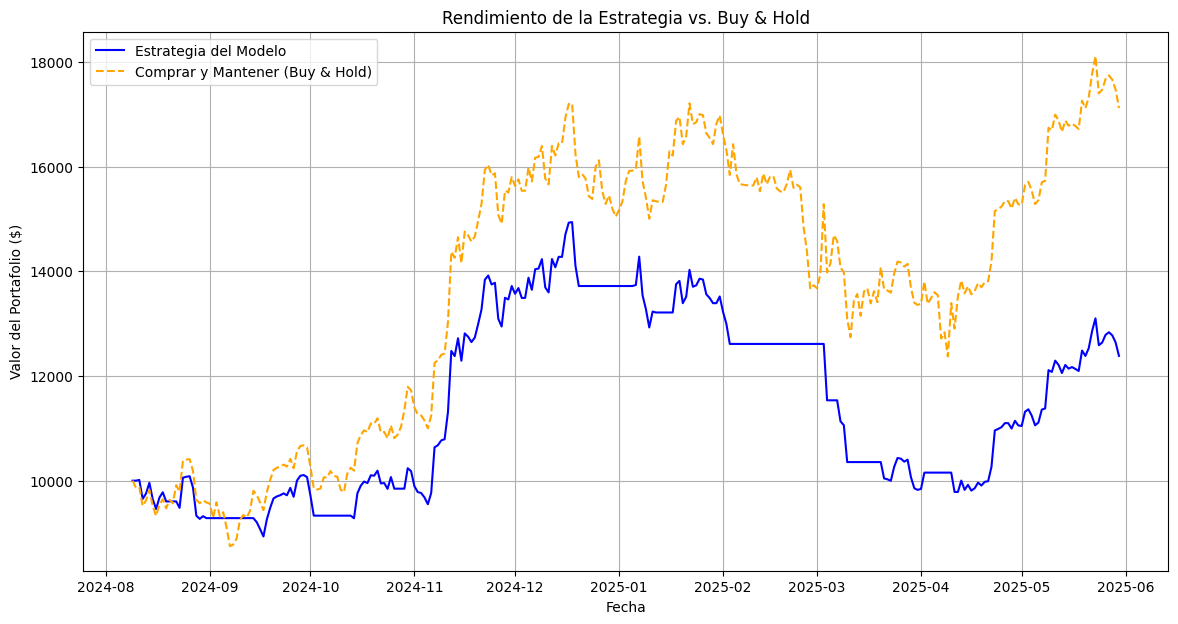

In [15]:
# --- Preparación de Datos para Backtesting ---

# 1. Obtener predicciones para el conjunto de prueba y mapearlas a -1, 0, 1
y_pred_test = np.vectorize(inv_map.get)(y_pred_test)

# 2. Crear un DataFrame para el backtest
# Usamos una copia del test_set original que contiene precios y fechas
backtest_df = test_set.copy()
backtest_df['signal'] = y_pred_test

# La columna de precio que usaremos es la del día más reciente en la ventana deslizante
# Basado en tu notebook dataCleaning.ipynb, esta columna debería existir. 
# Si el nombre es diferente, ajústalo aquí.
price_col = [col for col in test_set.columns if 'open_d0' in col][-1]


# --- Simulación de Backtesting ---

initial_capital = 10000.0
cash = initial_capital
position = 0.0  # Unidades de BTC
portfolio_values = []

for i, row in backtest_df.iterrows():
    price = row[price_col]
    signal = row['signal']
    
    # Lógica de trading
    if signal == 1 and cash > 0:  # Señal de compra
        position = cash / price
        cash = 0.0
    elif signal == -1 and position > 0:  # Señal de venta
        cash = position * price
        position = 0.0
    
    # Calcular el valor actual del portafolio
    current_portfolio_value = cash + position * price
    portfolio_values.append(current_portfolio_value)

backtest_df['portfolio_value'] = portfolio_values


# --- Cálculo de Métricas y Visualización ---

# 1. Calcular métricas de rendimiento
final_portfolio_value = backtest_df['portfolio_value'].iloc[-1]
total_return_pct = (final_portfolio_value - initial_capital) / initial_capital * 100
buy_and_hold_return_pct = (backtest_df[price_col].iloc[-1] - backtest_df[price_col].iloc[0]) / backtest_df[price_col].iloc[0] * 100

print("--- Resultados del Backtesting ---")
print(f"Capital Inicial: ${initial_capital:,.2f}")
print(f"Valor Final del Portafolio: ${final_portfolio_value:,.2f}")
print(f"Retorno Total de la Estrategia: {total_return_pct:.2f}%")
print(f"Retorno de Comprar y Mantener (Buy & Hold): {buy_and_hold_return_pct:.2f}%")

# 2. Visualizar los resultados
plt.figure(figsize=(14, 7))
plt.plot(backtest_df['date'], backtest_df['portfolio_value'], label='Estrategia del Modelo', color='blue')

# Normalizar el precio para comparar con "Buy & Hold"
buy_and_hold_values = (backtest_df[price_col] / backtest_df[price_col].iloc[0]) * initial_capital
plt.plot(backtest_df['date'], buy_and_hold_values, label='Comprar y Mantener (Buy & Hold)', color='orange', linestyle='--')

plt.title('Rendimiento de la Estrategia vs. Buy & Hold')
plt.xlabel('Fecha')
plt.ylabel('Valor del Portafolio ($)')
plt.legend()
plt.grid(True)
plt.show()

Compilacion y entrenamiento de la red SIN OPTUNA

In [16]:
# Definición de hiperparámetros
learning_rate = 0.001
n_l1 = 100 #100
n_l2 = 60  #60
n_l3 = 30  #30
n_l4 = 10  #10

# Definición del modelo
model = Sequential(
    [               
        tf.keras.Input(shape=(X_train.shape[1],)),
        Dense(n_l1,activation='relu',name='L1'),
        Dense(n_l2,activation='relu',name='L2'),
        Dense(n_l3,activation='relu',name='L3'),
        Dense(n_l4,activation='relu',name='L4'),
        Dense(3,activation='linear',name='L5'),
    ], name = "multiclass"
)

In [17]:
model.summary()

Model: "multiclass"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Dense)                  (None, 100)               6100      
                                                                 
 L2 (Dense)                  (None, 60)                6060      
                                                                 
 L3 (Dense)                  (None, 30)                1830      
                                                                 
 L4 (Dense)                  (None, 10)                310       
                                                                 
 L5 (Dense)                  (None, 3)                 33        
                                                                 
Total params: 14333 (55.99 KB)
Trainable params: 14333 (55.99 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
# Compilación del modelo
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    metrics=['accuracy']
)
# Detiene el entrenamiento si val_loss no mejora después de 10 épocas seguidas
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
# checkpoint = ModelCheckpoint(
#     filepath='best_model.keras',
#     monitor='val_loss',
#     save_best_only=True
# )
history = model.fit(
    X_train,y_train,
    epochs=60,
    validation_data=(X_val, y_val),
    callbacks=[early_stop], 
)


Epoch 1/60
43/43 [==============================] - 1s 10ms/step - loss: 1027.4259 - accuracy: 0.3086 - val_loss: 302.3402 - val_accuracy: 0.4320
Epoch 2/60
43/43 [==============================] - 0s 5ms/step - loss: 93.7573 - accuracy: 0.3741 - val_loss: 1.0893 - val_accuracy: 0.1531
Epoch 3/60
43/43 [==============================] - 0s 4ms/step - loss: 1.3548 - accuracy: 0.3428 - val_loss: 1.1037 - val_accuracy: 0.1395
Epoch 4/60
43/43 [==============================] - 0s 4ms/step - loss: 1.0992 - accuracy: 0.3188 - val_loss: 1.1017 - val_accuracy: 0.1395
Epoch 5/60
43/43 [==============================] - 0s 4ms/step - loss: 1.0966 - accuracy: 0.3188 - val_loss: 1.0994 - val_accuracy: 0.1395
Epoch 6/60
43/43 [==============================] - 0s 4ms/step - loss: 1.0961 - accuracy: 0.3450 - val_loss: 1.0973 - val_accuracy: 0.5408
Epoch 7/60
43/43 [==============================] - 0s 4ms/step - loss: 1.0957 - accuracy: 0.3763 - val_loss: 1.0947 - val_accuracy: 0.5408
Epoch 8/60
43

In [19]:
loss, accuracy = model.evaluate(X_val, y_val)

10/10 [==============================] - 0s 2ms/step - loss: 1.0673 - accuracy: 0.5408


Grafica de Loss y Accuracy en train_set & validation_set

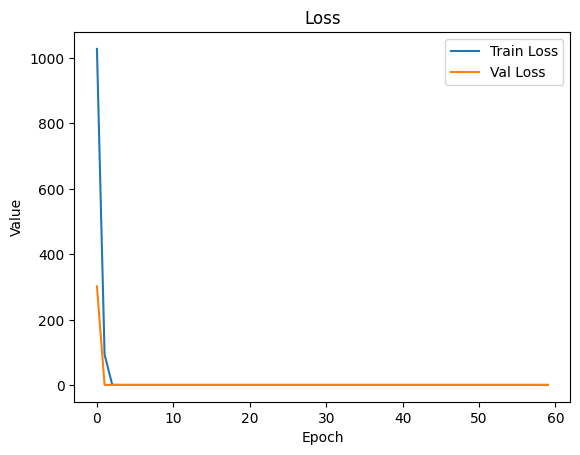

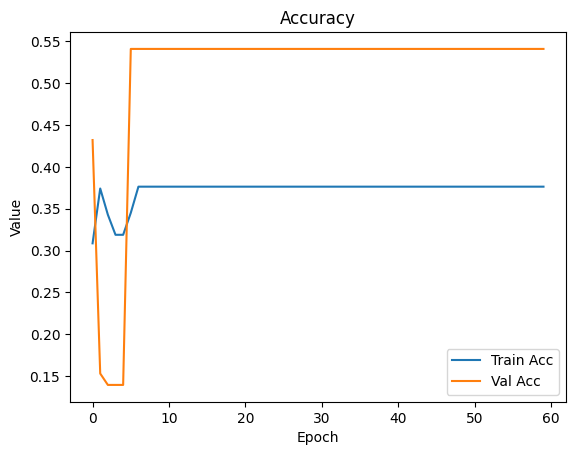

In [20]:
# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.show()


F1 SCORE

In [21]:
# Obtener predicciones
y_pred_val = np.argmax(model.predict(X_val), axis=1)
# Reporte completo: precisión, recall y F1 por clase
report = classification_report(y_val, y_pred_val, digits=4)
print("Multiclass Neural Network Report:\n", report)
print("Balanced accuracy:", balanced_accuracy_score(y_val, y_pred_val))


10/10 [==============================] - 0s 2ms/step
Multiclass Neural Network Report:
               precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        94
           1     0.0000    0.0000    0.0000        41
           2     0.5408    1.0000    0.7020       159

    accuracy                         0.5408       294
   macro avg     0.1803    0.3333    0.2340       294
weighted avg     0.2925    0.5408    0.3796       294

Balanced accuracy: 0.3333333333333333


/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [22]:
print("Multiclass Neural Network trend_changes_score:\n",
    trend_changes_score(y_val, y_pred_val)
)

Multiclass Neural Network trend_changes_score:
               precision    recall  f1-score   support

       False     0.8840    1.0000    0.9384       259
        True     0.0000    0.0000    0.0000        34

    accuracy                         0.8840       293
   macro avg     0.4420    0.5000    0.4692       293
weighted avg     0.7814    0.8840    0.8295       293



/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/toyotx22/bitcoin_sentiment_forecaster/tf_venv2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

